[참고](https://https://github.com/A1R-3112/SentenceBERT_with_Eldenring_Review/blob/main/SentenceBERT_%EC%97%98%EB%93%A0%EB%A7%81_%EB%A6%AC%EB%B7%B0_%ED%81%B4%EB%9F%AC%EC%8A%A4%ED%84%B0%EB%A7%81.ipynb)

# 분석목적
- 순서
    - 답변이 텍스트인 경우에만 bert 모델 이용
    - 질문
        - **[1]**  팬 여러분들이 더욱 편하게 즐기고 가실 수 있도록 저희가 어떤 점을 개선해 나아가면 좋을까요?
        - **[2]**   마지막으로 인천유나이티드에 바라는 점이나 하고 싶은 이야기가 있으신가요?
        - **[3]**  시즌권 구매시 가장 중요한 점은?(가격, 기념품, 혜택, 충성심 등)
        - **[4]**  시즌권 구매시 가장 고려하지 않는 점은?(가격, 기념품, 혜택, 충성심 등)
        - **[5]**  현재 멤버십 제도에서 가장 만족하는 점은?
        - **[6]**  과거에 경기장으로 오신 적이 있다면 최근 경기장에 방문하지 못했던 이유는 무엇인가요?
        - **[7]**  2021 시즌권 요청, 건의사항

In [ ]:
!nvidia-smi
# Sentence Transformers 패키지 
!pip install -q -U sentence-transformers

# 문장 임베딩

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('jhgan/ko-sroberta-multitask')

In [ ]:
sentences = ["안녕하세요?", "한국어 문장 임베딩을 위한 버트 모델입니다."]
embeddings = model.encode(sentences)

print(embeddings)

## 파일 불러오기 

In [66]:
import pandas as pd 
survey = pd.read_csv('/content/survey.csv')
# survey_2022 = survey[survey['start_date'].str.contains('2022')].reset_index(drop = True)

In [67]:
survey_new = survey.groupby(['subject','MB_IDX', 'start_date','item_type','MB_AGE','job','favorite_idx'])['answer_content'].agg('first').reset_index()
survey_T = survey_new[survey_new['item_type']=='T']

In [35]:
survey_T1 = survey_T[survey_T['subject']=='팬 여러분들이 더욱 편하게 즐기고 가실 수 있도록 저희가 어떤 점을 개선해 나아가면 좋을까요?']

In [36]:
survey_T2 = survey_T[survey_T['subject']=='마지막으로 인천유나이티드에 바라는 점이나 하고 싶은 이야기가 있으신가요?']

In [ ]:
survey_T3 = survey_T[survey_T['subject']=='시즌권 구매시 가장 중요한 점은?(가격, 기념품, 혜택, 충성심 등)']

In [ ]:
survey_T4 = survey_T[survey_T['subject']=='시즌권 구매시 가장 고려하지 않는 점은?(가격, 기념품, 혜택, 충성심 등)']

In [ ]:
survey_T5 = survey_T[survey_T['subject']=='현재 멤버십 제도에서 가장 만족하는 점은?']

In [ ]:
survey_T6 = survey_T[survey_T['subject']=='과거에 경기장으로 오신 적이 있다면 최근 경기장에 방문하지 못했던 이유는 무엇인가요?']

In [ ]:
survey_T7 = survey_T[survey_T['subject']=='2021 시즌권 요청, 건의사항']

## 전처리 
 - 한글이 아닌 글자
 - 작은 따옴표 제거 
 - 연속된 공백제거
 - 좌우 공백 제거 
 - 최대글자 225

In [70]:
survey_T['answer_content'] =survey_T['answer_content'] \
  .replace(r'[^가-힣 ]', ' ', regex=True) \
  .replace("'", '') \
  .replace(r'\s+', ' ', regex=True) \
  .str.strip() \
  .str[:255]

<ipython-input-70-7379e1d8ace5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey_T['answer_content'] =survey_T['answer_content'] \


In [72]:
survey_T['answer_content'].values.tolist()[:5]

['커플이나 가족 시즌권 있음 좋을것 같아요',
 '프리미엄 시즌권이 없어진게 아쉬움',
 '직관을 못해서 아쉽습니다',
 '디자인이 더 특색있고 예뻤으면 좋겠어요',
 '여러사람에게 관람기회를 준다며 프리미엄석 시즌권을 판매 하지 않았으나 정작 해당 좌석은 텅텅 비었음 과연 누구의 기획으로 판매 하지 않은것인지 해당 책임자에 대한 문책이 꼭 필요']

### CSV 파일 저장

In [73]:
survey_T.to_csv('survey_T202122.csv', index=False)

### 임베딩

In [ ]:
corpus = survey_T['answer_content'].values.tolist()

embeddings = model.encode(corpus)

embeddings[:5]

## 워드클라우드

### 형태소 분석, 명사 추출

In [75]:
!pip install -q konlpy tqdm

### 팬 여러분들이 더욱 편하게 즐기고 가실 수 있도록 저희가 어떤 점을 개선해 나아가면 좋을까요?

In [91]:
survey_T1 = survey_T[survey_T['subject']=='팬 여러분들이 더욱 편하게 즐기고 가실 수 있도록 저희가 어떤 점을 개선해 나아가면 좋을까요?']

In [92]:
from konlpy.tag import Komoran, Okt, Kkma, Hannanum
from tqdm import tqdm

extractor = Hannanum()

nouns = []

for review in tqdm(survey_T1['answer_content'].values.tolist()):
    nouns.extend(extractor.nouns(review))

len(nouns)

100%|██████████| 209/209 [00:00<00:00, 224.51it/s]


708

In [93]:
from collections import Counter

count = Counter(nouns)
words = dict(count.most_common())

for i, (word, count) in enumerate(words.items()):
    if i > 10:
        break

    print(word, count)

수 17
것 17
좌석 13
이벤트 11
주차 9
다양 9
주차장 9
전광판 9
내 8
먹거리 8
다양한 7


In [94]:
!wget https://github.com/kairess/MBTI-wordcloud/raw/master/NanumSquareRoundR.ttf

--2023-02-06 18:10:14--  https://github.com/kairess/MBTI-wordcloud/raw/master/NanumSquareRoundR.ttf
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kairess/MBTI-wordcloud/master/NanumSquareRoundR.ttf [following]
--2023-02-06 18:10:14--  https://raw.githubusercontent.com/kairess/MBTI-wordcloud/master/NanumSquareRoundR.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1063276 (1.0M) [application/octet-stream]
Saving to: ‘NanumSquareRoundR.ttf.2’

NanumSquareRoundR.t 100%[===================>]   1.01M  --.-KB/s    in 0.008s  

2023-02-06 18:10:15 (126 MB/s) - ‘NanumSquareRoundR.ttf.2’ saved [

In [95]:
del(words['수'])
del(words['것'])

In [98]:
del(words['들'])
del(words['앞'])
del(words['때'])

KeyError: ignored

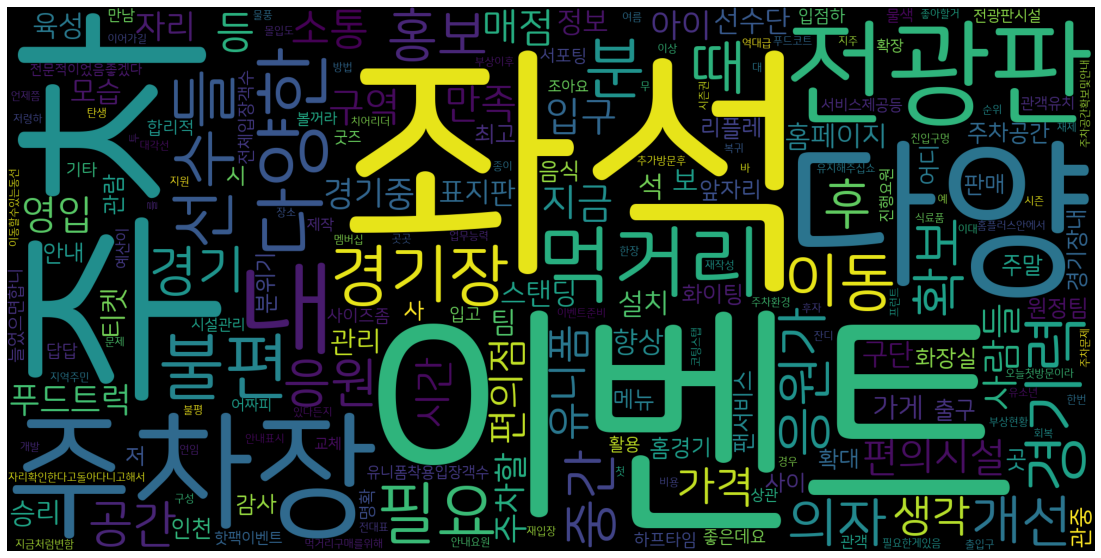

In [99]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(
    font_path='NanumSquareRoundR.ttf',
    width=2000,
    height=1000
).generate_from_frequencies(words)

plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

### 마지막으로 인천유나이티드에 바라는 점이나 하고 싶은 이야기가 있으신가요?

In [81]:
survey_T2 = survey_T[survey_T['subject']=='마지막으로 인천유나이티드에 바라는 점이나 하고 싶은 이야기가 있으신가요?']

In [82]:
from konlpy.tag import Komoran, Okt, Kkma, Hannanum
from tqdm import tqdm

extractor = Hannanum()

nouns = []

for review in tqdm(survey_T2['answer_content'].values.tolist()):
    nouns.extend(extractor.nouns(review))

len(nouns)

100%|██████████| 3501/3501 [00:07<00:00, 451.47it/s]


13359

In [83]:
from collections import Counter

count = Counter(nouns)
words = dict(count.most_common())

for i, (word, count) in enumerate(words.items()):
    if i > 10:
        break

    print(word, count)

화이팅 449
수 288
인천 269
경기 224
오늘 151
것 141
응원 128
감사 108
아챔 96
잔디 96
선수들 91


In [84]:
del(words['것'])
del(words['들'])
del(words['수'])
del(words['때'])
del(words['데'])
del(words['내'])

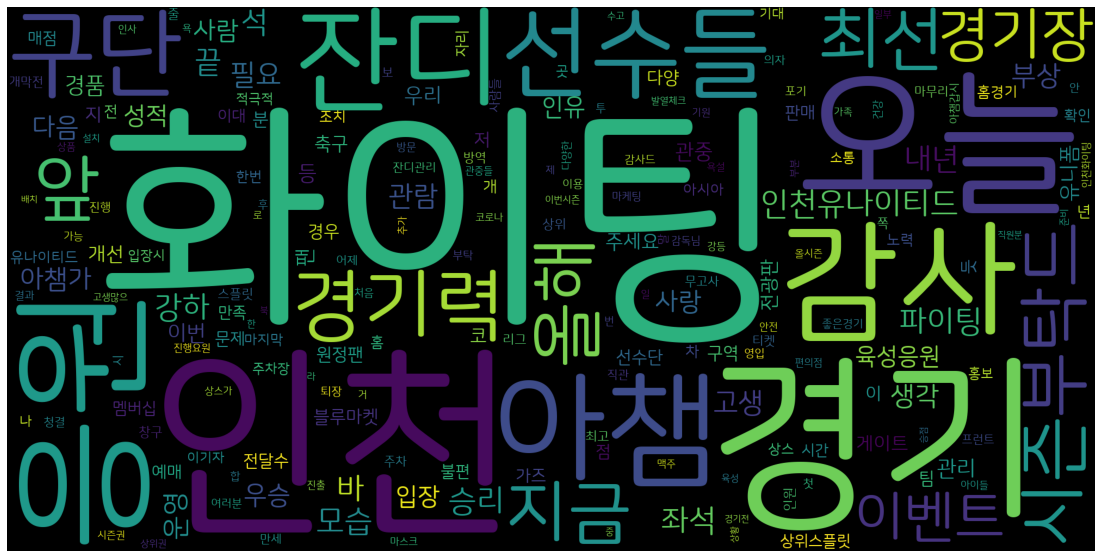

In [85]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(
    font_path='NanumSquareRoundR.ttf',
    width=2000,
    height=1000
).generate_from_frequencies(words)

plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

### 시즌권 구매시 가장 중요한 점은?(가격, 기념품, 혜택, 충성심 등)

In [100]:
survey_T3 = survey_T[survey_T['subject']=='시즌권 구매시 가장 중요한 점은?(가격, 기념품, 혜택, 충성심 등)']

In [101]:
from konlpy.tag import Komoran, Okt, Kkma, Hannanum
from tqdm import tqdm

extractor = Hannanum()

nouns = []

for review in tqdm(survey_T3['answer_content'].values.tolist()):
    nouns.extend(extractor.nouns(review))

len(nouns)

100%|██████████| 350/350 [00:02<00:00, 159.28it/s]


605

In [102]:
from collections import Counter

count = Counter(nouns)
words = dict(count.most_common())

for i, (word, count) in enumerate(words.items()):
    if i > 10:
        break

    print(word, count)

가격 124
혜택 92
충성심 92
기념품 74
팀 10
인천 9
애정 8
시즌권 8
팬심 7
좌석 6
수 6


In [104]:
del(words['수'])

In [ ]:
!wget https://github.com/kairess/MBTI-wordcloud/raw/master/NanumSquareRoundR.ttf

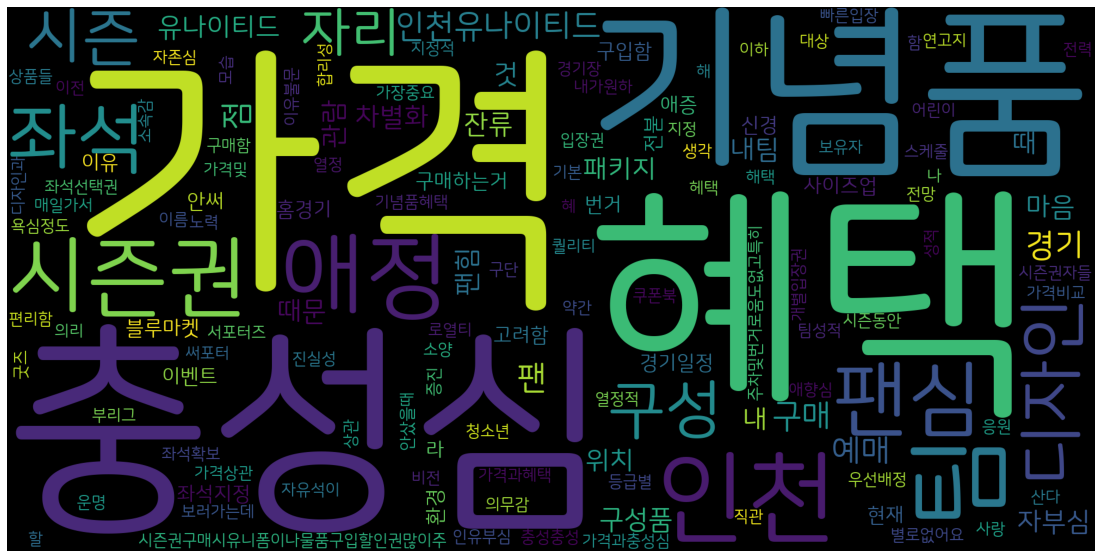

In [105]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(
    font_path='NanumSquareRoundR.ttf',
    width=2000,
    height=1000
).generate_from_frequencies(words)

plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

### 시즌권 구매시 가장 고려하지 않는 점은?(가격, 기념품, 혜택, 충성심 등)

In [109]:
survey_T4 = survey_T[survey_T['subject']=='시즌권 구매시 가장 고려하지 않는 점은?(가격, 기념품, 혜택, 충성심 등)']

In [110]:
from konlpy.tag import Komoran, Okt, Kkma, Hannanum
from tqdm import tqdm

extractor = Hannanum()

nouns = []

for review in tqdm(survey_T4['answer_content'].values.tolist()):
    nouns.extend(extractor.nouns(review))

len(nouns)

100%|██████████| 331/331 [00:02<00:00, 156.21it/s]


384

In [111]:
from collections import Counter

count = Counter(nouns)
words = dict(count.most_common())

for i, (word, count) in enumerate(words.items()):
    if i > 10:
        break

    print(word, count)

가격 94
기념품 80
혜택 67
충성심 46
디자인 9
성적 6
것 5
인천 4
횟수 2
팀 2
구단 2


In [113]:
del(words['것'])

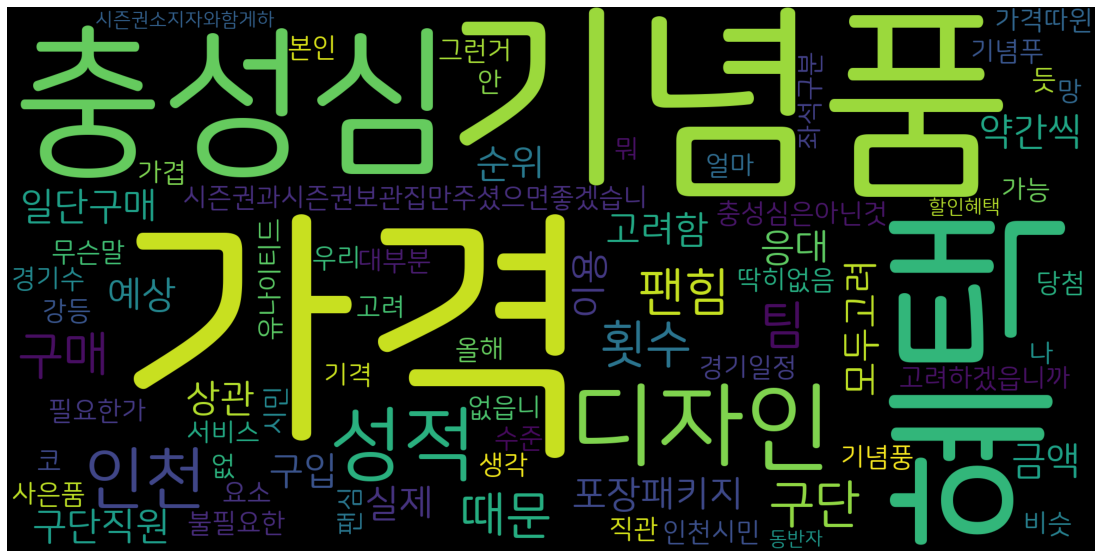

In [114]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(
    font_path='NanumSquareRoundR.ttf',
    width=2000,
    height=1000
).generate_from_frequencies(words)

plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

### 현재 멤버십 제도에서 가장 만족하는 점은?

In [115]:
survey_T5 = survey_T[survey_T['subject']=='현재 멤버십 제도에서 가장 만족하는 점은?']

In [116]:
from konlpy.tag import Komoran, Okt, Kkma, Hannanum
from tqdm import tqdm

extractor = Hannanum()

nouns = []

for review in tqdm(survey_T5['answer_content'].values.tolist()):
    nouns.extend(extractor.nouns(review))

len(nouns)

100%|██████████| 293/293 [00:01<00:00, 226.68it/s]


465

In [117]:
from collections import Counter

count = Counter(nouns)
words = dict(count.most_common())

for i, (word, count) in enumerate(words.items()):
    if i > 10:
        break

    print(word, count)

선예 152
선예매 42
예매 15
할인권 10
유니폼 9
수 9
혜택 8
티켓 7
선예매제 6
것 5
우선예매 5


In [118]:
del(words['것'])
del(words['수'])
del(words['선예'])


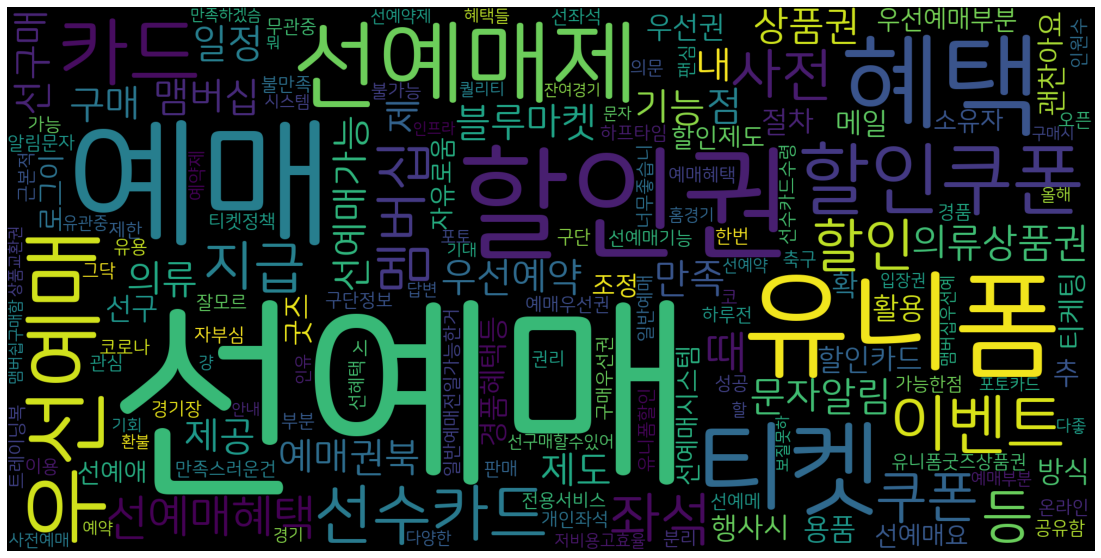

In [119]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(
    font_path='NanumSquareRoundR.ttf',
    width=2000,
    height=1000
).generate_from_frequencies(words)

plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

### 과거에 경기장으로 오신 적이 있다면 최근 경기장에 방문하지 못했던 이유는 무엇인가요?

In [120]:
survey_T6 = survey_T[survey_T['subject']=='과거에 경기장으로 오신 적이 있다면 최근 경기장에 방문하지 못했던 이유는 무엇인가요?']

In [123]:
from konlpy.tag import Komoran, Okt, Kkma, Hannanum
from tqdm import tqdm

extractor = Hannanum()

nouns = []

for review in tqdm(survey_T6['answer_content'].values.tolist()):
    nouns.extend(extractor.nouns(review))

len(nouns)

100%|██████████| 258/258 [00:01<00:00, 245.89it/s]


360

In [124]:
from collections import Counter

count = Counter(nouns)
words = dict(count.most_common())

for i, (word, count) in enumerate(words.items()):
    if i > 10:
        break

    print(word, count)

코 20
시간 16
방문 16
오늘 13
관심 13
학업 8
첫방문 8
일정 8
경기장 8
최근 7
일 6


In [125]:
del(words['코'])

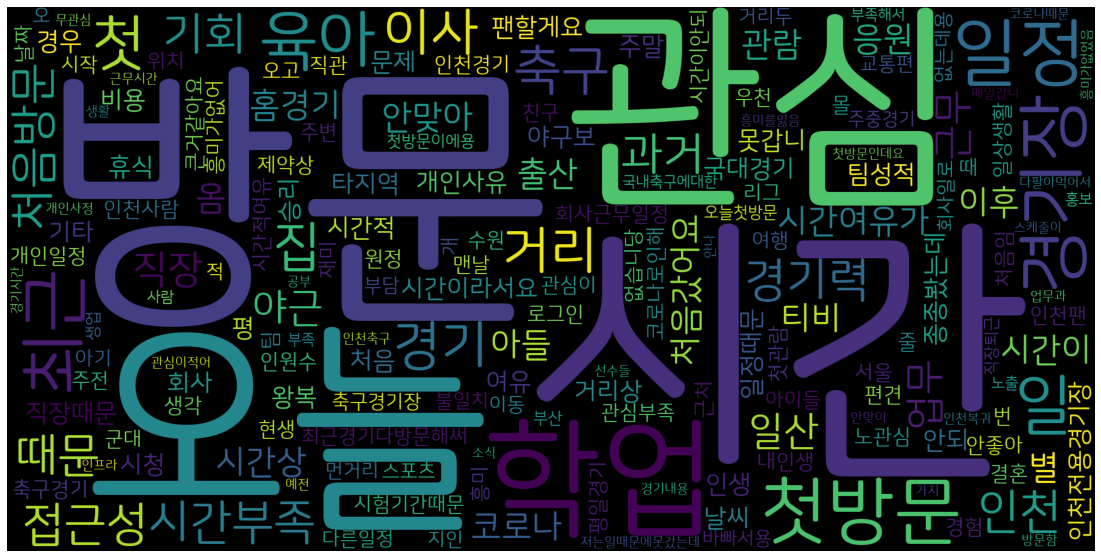

In [126]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(
    font_path='NanumSquareRoundR.ttf',
    width=2000,
    height=1000
).generate_from_frequencies(words)

plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

### 2021 시즌권 요청, 건의사항

In [127]:
survey_T7 = survey_T[survey_T['subject']=='2021 시즌권 요청, 건의사항']

In [129]:
from konlpy.tag import Komoran, Okt, Kkma, Hannanum
from tqdm import tqdm

extractor = Hannanum()

nouns = []

for review in tqdm(survey_T7['answer_content'].values.tolist()):
    nouns.extend(extractor.nouns(review))

len(nouns)

100%|██████████| 237/237 [00:01<00:00, 137.05it/s]


1248

In [130]:
from collections import Counter

count = Counter(nouns)
words = dict(count.most_common())

for i, (word, count) in enumerate(words.items()):
    if i > 10:
        break

    print(word, count)

시즌권 80
수 34
것 30
혜택 27
기념품 25
코 21
판매 20
카드 15
가격 14
티켓북 12
구매 12


In [131]:
del(words['수'])
del(words['것'])
del(words['코'])

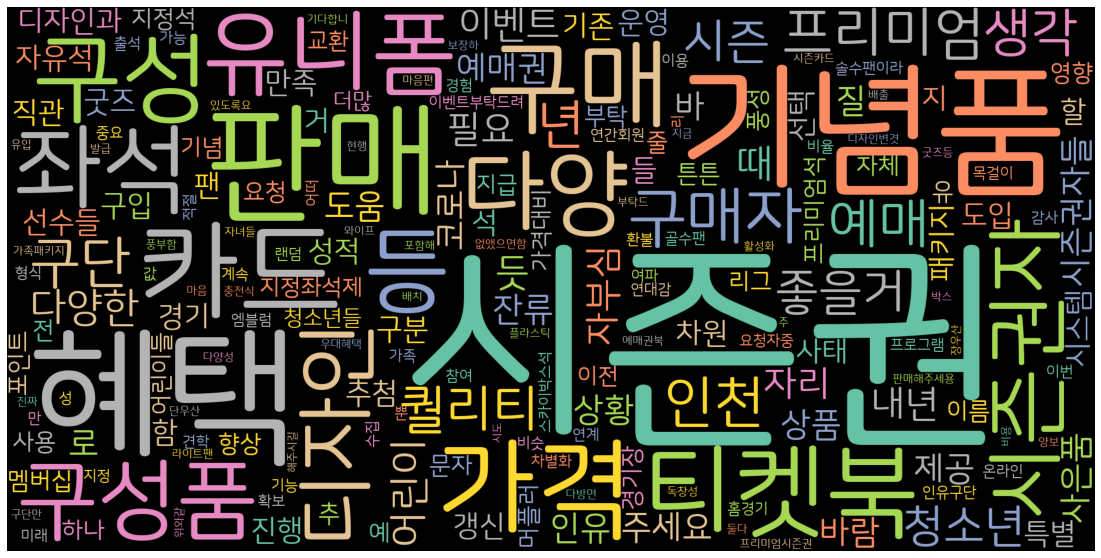

In [143]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(
    font_path= 'NanumSquareRoundR.ttf',
    colormap = 'Set2',
    # background_color = 'PuRd',
    width=2000,
    height=1000
).generate_from_frequencies(words)

plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()